# HW 8
### Bond yields and Sell Your Soul to the Devil

## Question 1

Tyler, Jaden, Matthew, Marco

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For data from FRED
from fredapi import Fred
import pandas_datareader.data as pdr

# For Markov chain / stats
import statsmodels.api as sm

# For solving equations (certainty equivalent)
from scipy.optimize import fsolve

### Part 1: Plot a histogram with 20 bins, and save the output. 

In [2]:
fred = Fred(api_key='6c0ecd6565503b64631fd2b36f71293a')
fred = Fred(api_key='YOUR_FRED_API_KEY_HERE')  # <-- Replace with your actual key
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()
wei_data = pdr.DataReader("WEI", "fred", start, end)

print("Recent WEI observations:")
print(wei_data.tail())

Recent WEI observations:
             WEI
DATE            
2025-02-01  2.38
2025-02-08  2.53
2025-02-15  2.50
2025-02-22  2.43
2025-03-01  2.24


### Part 2:  
i. Group the data by mean growth rates within each bin.  
ii. Estimate the Markov matrix describing the transitions between states.  

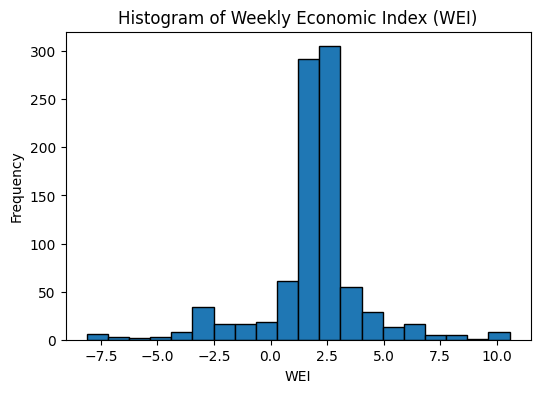

Histogram bin counts: [  6.   3.   2.   3.   8.  34.  16.  16.  18.  61. 292. 305.  55.  29.
  13.  16.   5.   5.   1.   8.]
Histogram bin edges: [-8.12  -7.186 -6.252 -5.318 -4.384 -3.45  -2.516 -1.582 -0.648  0.286
  1.22   2.154  3.088  4.022  4.956  5.89   6.824  7.758  8.692  9.626
 10.56 ]


In [3]:
plt.figure(figsize=(6,4))
counts, bins, patches = plt.hist(
    wei_data['WEI'].dropna(), bins=20, edgecolor='black'
)
plt.title('Histogram of Weekly Economic Index (WEI)')
plt.xlabel('WEI')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

print("Histogram bin counts:", counts)
print("Histogram bin edges:", bins)

In [4]:
q33, q67 = wei_data['WEI'].quantile([0.33, 0.67])

def classify_wei(x):
    if x < q33:
        return 0  # Low
    elif x < q67:
        return 1  # Medium
    else:
        return 2  # High

wei_data['State'] = wei_data['WEI'].apply(classify_wei)

# Shift by 1 to see transitions from state_t to state_{t+1}
wei_data['NextState'] = wei_data['State'].shift(-1)

# Drop last row (no NextState)
wei_data_markov = wei_data.dropna(subset=['NextState'])

# Transition counts
transition_counts = pd.crosstab(wei_data_markov['State'], wei_data_markov['NextState'])
# Convert to row probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

print("\nEstimated 3x3 Markov transition matrix (rows sum to 1):")
print(transition_matrix)


Estimated 3x3 Markov transition matrix (rows sum to 1):
NextState       0.0       1.0       2.0
State                                  
0          0.841216  0.152027  0.006757
1          0.149007  0.682119  0.168874
2          0.006734  0.171717  0.821549


In [6]:
# Prepare data
wei_data_markov = wei_data_markov.copy()
wei_data_markov['Growth'] = wei_data_markov['WEI'] / 100.0  # naive example

beta_weekly = 0.97**(1/52)
gamma = 2

# Average growth by state
state_means = wei_data_markov.groupby('State')['Growth'].mean()

# State-dependent single-step SDF:
#   m_i = beta_weekly * (1 + growth_i)^(-gamma)
sdf_by_state = {}
for s in state_means.index:
    g_s = state_means[s]
    sdf_by_state[s] = beta_weekly * (1 + g_s)**(-gamma)

# Sort states in ascending order (0,1,2) for consistency
states_sorted = sorted(sdf_by_state.keys())
sdf_vector = np.array([sdf_by_state[s] for s in states_sorted])

# Convert transition_matrix (DataFrame) to NumPy
M = transition_matrix.to_numpy()
M


array([[0.84121622, 0.15202703, 0.00675676],
       [0.14900662, 0.68211921, 0.16887417],
       [0.00673401, 0.17171717, 0.82154882]])

### Part : Markov chain-based bond yields
iii. Use that Markov matrix to estimate the gross yields on one-year and thirty-year bonds for each state.

$$m_{t+1} \;=\; \beta^{1/52} \,\left(\frac{C_{t+1}}{C_t}\right)^{-\gamma}$$

Here, $\beta^{1/52}\approx 0.97^{1/52}.$


Bond Prices and Yields by State:

State 0:
  1-year bond price = 0.208454, yield = 379.7224%
  30-year bond price = 0.000000, yield = 471.6965%

State 1:
  1-year bond price = 0.164830, yield = 506.6839%
  30-year bond price = 0.000000, yield = 476.1887%

State 2:
  1-year bond price = 0.135478, yield = 638.1256%
  30-year bond price = 0.000000, yield = 479.9677%



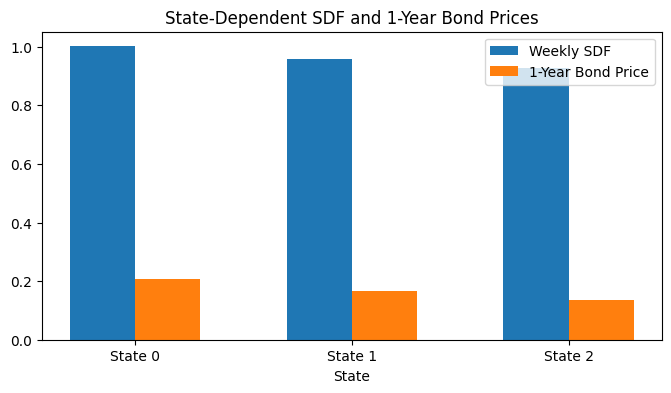

In [7]:
def bond_price(M, sdf, T):
    """
    Computes the price of a zero-coupon bond paying 1 at time T,
    using a Markov chain with state-dependent SDFs.
    M: Markov transition matrix (n x n)
    sdf: vector of state-dependent pricing kernels (n,)
    T: horizon in discrete steps (weeks, here)
    """
    n = len(sdf)
    # At maturity, payoff = 1 in each state
    P = np.ones(n)
    # Work backwards T times
    for _ in range(T):
        P = sdf * (M @ P)
    return P

# --- Price 1-year bond (52 weeks)
T_1yr = 52
price_1yr = bond_price(M, sdf_vector, T_1yr)

# --- Price 30-year bond (52*30 = 1560 weeks)
T_30yr = 52 * 30
price_30yr = bond_price(M, sdf_vector, T_30yr)

print("\nBond Prices and Yields by State:\n")
for i, s in enumerate(states_sorted):
    p1 = price_1yr[i]
    p30 = price_30yr[i]
    # Gross yields = 1/p
    gross_yield_1yr = 1.0 / p1
    gross_yield_30yr = 1.0 / p30
    # Annualized yield in %: (gross_yield - 1)*100
    # Because these are 1-year or 30-year instruments already annualized.
    # (If you prefer yield to maturity, it's effectively gross_yield - 1, but here we keep it simple.)
    ann_yield_1yr = (gross_yield_1yr - 1)*100
    # For 30-year, you might prefer to do the 30th-root to get an annual yield to maturity, i.e.:
    #   annual_factor = gross_yield_30yr ** (1/30)
    #   annual_yield_30yr = (annual_factor - 1)*100
    #
    # Below we do the correct 30-year yield to maturity:
    annual_factor_30 = gross_yield_30yr ** (1/30)
    annual_yield_30yr = (annual_factor_30 - 1)*100
    
    print(f"State {s}:")
    print(f"  1-year bond price = {p1:.6f}, yield = {ann_yield_1yr:.4f}%")
    print(f"  30-year bond price = {p30:.6f}, yield = {annual_yield_30yr:.4f}%")
    print("")

# Optional: plot SDF and 1-year bond prices
plt.figure(figsize=(8,4))
plt.bar(np.arange(len(sdf_vector)) - 0.15, sdf_vector, width=0.3, label='Weekly SDF')
plt.bar(np.arange(len(price_1yr)) + 0.15, price_1yr, width=0.3, label='1-Year Bond Price')
plt.xticks(np.arange(len(sdf_vector)), [f"State {s}" for s in states_sorted])
plt.xlabel("State")
plt.title("State-Dependent SDF and 1-Year Bond Prices")
plt.legend()
plt.show()

# Question 2. Von Neumann–Morgenstern Utility
## Part 1: Plotting utility function


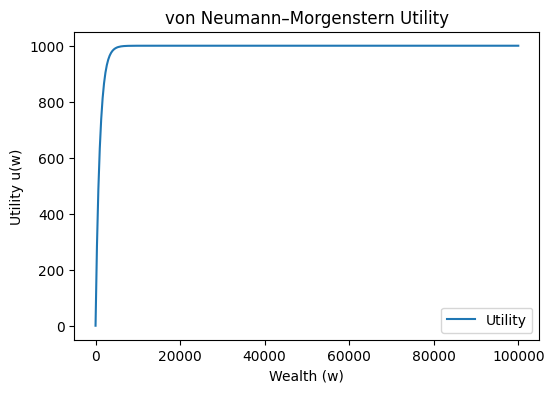

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 2a. Define utility
def u(w, gamma=1/1000):
    """
    Von Neumann–Morgenstern utility:
        u(w) = (1 - e^(-gamma*w)) / gamma
    """
    return (1 - np.exp(-gamma*w)) / gamma

# 2b. Plot utility function from 0 to 100,000
w_vals = np.linspace(0, 100000, 300)
u_vals = [u(wi) for wi in w_vals]

plt.figure(figsize=(6,4))
plt.plot(w_vals, u_vals, label="Utility")
plt.xlabel("Wealth (w)")
plt.ylabel("Utility u(w)")
plt.title("von Neumann–Morgenstern Utility")
plt.legend()
plt.show()

Looking at the plot of the utility function, we can see that before wealth reaches $10,000, there marginal utility of additional wealth is very high and then begins to asymptotically approach 1000 after that. This indicates that there is more to be gained from additional wealth when relatively poor than compared to rich.

## Part 2: 50-50 gamble that loses $100 or wins $110, when  initial wealth is $30,000

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd

# Define utility function
def u(w, gamma=1/1000):
    return (1 - np.exp(-gamma * w)) / gamma

# Define first and second derivatives of utility function
def uprime(w, gamma=1/1000):
    return np.exp(-gamma * w)

def udoubleprime(w, gamma=1/1000):
    return gamma * np.exp(-gamma * w)

# Given parameters
initial_wealth = 30000
loss = 100
gain = 110

# Expected utility of the gamble
EU_gamble = 0.5 * u(initial_wealth + gain) + 0.5 * u(initial_wealth - loss)
U_initial = u(initial_wealth)

# Certainty equivalent: solve u(CE) = EU_gamble
CE = fsolve(lambda w: u(w) - EU_gamble, initial_wealth)[0]

# Compute marginal utilities
MU_gain = uprime(initial_wealth + gain)
MU_loss = uprime(initial_wealth - loss)

# Display results
results = {
    "Expected Utility of Gamble": [EU_gamble],
    "Utility at Initial Wealth": [U_initial],
    "Certainty Equivalent": [CE],
    "Marginal Utility of Gaining $100": [MU_gain],
    "Marginal Utility of Losing $110": [MU_loss],
    "MU Loss > MU Gain": [MU_loss > MU_gain]
}

print(f"Expected Utility of Gamble: {EU_gamble}")
print(f"Utility at Initial Wealth: {U_initial}")
print(f"Certainty Equivalent: {CE}")
print(f"Marginal Utility of Gaining $100: {MU_gain}")
print(f"Marginal Utility of Losing $110: {MU_loss}")
print(f"MU Loss > MU Gain: {MU_loss > MU_gain}")

Certainty Equivalent: 29999.07
Expected Utility of Gamble: 999.9999999999063
Utility at Initial Wealth: 999.9999999999064
Certainty Equivalent: 29999.06909090909
Marginal Utility of Gaining $100: 8.382878080721875e-14
Marginal Utility of Losing $110: 1.0341772767478841e-13
MU Loss > MU Gain: True


Since the certainty equilavent of this offer is less than our initial wealth of $30,000 and the marginal utility of losing $110 is larger than the marginal utility of gaining $100, we reject this offer.

## 50-50 chance of infinite wealth for cost of $1000 

In [27]:
# Given parameters
initial_wealth = 30000
loss = 1000
gain = np.inf  # Infinite wealth

# Compute expected utility of the gamble
EU_gamble = 0.5 * u(initial_wealth + gain) + 0.5 * u(initial_wealth - loss)
U_initial = u(initial_wealth)

# Solve for the certainty equivalent
CE = fsolve(lambda w: u(w) - EU_gamble, initial_wealth)[0]
print(f"Certainty Equivalent: {CE:.2f}")

# Compute marginal utilities
MU_gain = uprime(initial_wealth + gain)  # Approaches 0 as wealth goes to infinity
MU_loss = uprime(initial_wealth - loss)
print(f'Marginal Utility of gaining infinite wealth: {MU_gain}')
print(f'Marginal Utility of losing $1000 wealth: {MU_loss}')


Certainty Equivalent: 30000.00
Marginal Utility of gaining infinite wealth: 0.0
Marginal Utility of losing $1000 wealth: 2.543665647376923e-13


SInce the certainty equivalents are the same, we have to look at the marginal utility of gaining vs losing that money. Since the marginal utility of gaining infinite wealth is less than the marginal utility of losing $1000 dollars, we do not take the gamble.

## 50-50 chance of infinite wealth for cost of $500 

In [28]:
# Given parameters
initial_wealth = 30000
loss = 500
gain = np.inf  # Infinite wealth

# Compute expected utility of the gamble
EU_gamble = 0.5 * u(initial_wealth + gain) + 0.5 * u(initial_wealth - loss)
U_initial = u(initial_wealth)

# Solve for the certainty equivalent
CE = fsolve(lambda w: u(w) - EU_gamble, initial_wealth)[0]

print(f"Certainty Equivalent: {CE:.2f}")

# Compute marginal utilities
MU_gain = uprime(initial_wealth + gain)  # Approaches 0 as wealth goes to infinity
MU_loss = uprime(initial_wealth - loss)
print(f'Marginal Utility of gaining infinite wealth: {MU_gain}')
print(f'Marginal Utility of losing $1000 wealth: {MU_loss}')

Certainty Equivalent: 30192.97
Marginal Utility of gaining infinite wealth: 0.0
Marginal Utility of losing $1000 wealth: 1.5428112031918877e-13


Since the certainty equivalent of this gamble is larger than our initial starting wealth we take the gamble for the cost of $500.